## Pipeline Acceidents

For making maps I used this: https://jcutrer.com/python/learn-geopandas-plotting-usmaps

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import geopandas
from shapely.geometry import Point  #To display lat-long locations on the maps



## Getting the shape data 

In [164]:
states = geopandas.read_file('data/mapping/usa-states-census-2014.shp')
states.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS                  NAME LSAD  \
0      06  01779778  0400000US06    06     CA            California   00   
1      11  01702382  0400000US11    11     DC  District of Columbia   00   
2      12  00294478  0400000US12    12     FL               Florida   00   
3      13  01705317  0400000US13    13     GA               Georgia   00   
4      16  01779783  0400000US16    16     ID                 Idaho   00   

          ALAND       AWATER     region  \
0  403483823181  20483271881       West   
1     158350578     18633500  Northeast   
2  138903200855  31407883551  Southeast   
3  148963503399   4947080103  Southeast   
4  214045425549   2397728105       West   

                                            geometry  
0  MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...  
1  POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...  
2  MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...  
3  POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...  
4  POLYGON Z ((-117.24303 44.39097 0.00000, -117....

https://www.eia.gov/maps/layer_info-m.php for the shape files

<AxesSubplot:>

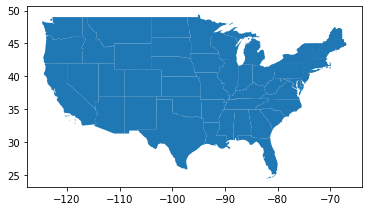

In [165]:
#PLOTTING

states.plot()


In [166]:
## Getting the crude pipeline data
crude_pipe = geopandas.read_file('data/mapping/CrudeOil_Pipelines_US_202001.shp')

crude_pipe_clipped = geopandas.clip(crude_pipe, states)  #using the clip() function, and clipping the pipeline data to the continental USA boundaries.

crude_pipe_clipped.head()

geometry
0  LINESTRING Z (-95.38768 47.70825 0.00000, -96....
1  LINESTRING Z (-78.78838 42.87786 0.00000, -78....
2  LINESTRING Z (-89.09530 38.75530 0.00000, -88....
3  LINESTRING Z (-97.53267 49.00058 0.00000, -96....
4  LINESTRING Z (-92.06769 46.68275 0.00000, -88....

In [167]:
## Getting the HGL (Hydrocarbon Liquid Gass) transmission pieline data

HGL_trans_pipe = geopandas.read_file('data/mapping/HGL_Pipelines_US_202001.shp')
HGL_trans_pipe_clipped = geopandas.clip(HGL_trans_pipe, states)  #using the clip() function, and clipping the pipeline data to the continental USA boundaries.
HGL_trans_pipe_clipped.head()

geometry
0  LINESTRING Z (-103.89261 31.80733 0.00000, -10...
2  LINESTRING Z (-109.27388 41.36037 0.00000, -10...
3  LINESTRING Z (-102.95441 32.78174 0.00000, -10...
4  LINESTRING Z (-102.90345 32.80142 0.00000, -10...
5  LINESTRING Z (-97.72963 38.18854 0.00000, -96....

In [168]:
#Gulf of Mexico Pipelines (undersea)
#https://www.data.boem.gov/Main/Mapping.aspx

Gulf_mexico_pipe = geopandas.read_file('data/mapping/ppl_arcs.shp')

In [169]:
#interstate and intrastate pipes

inter_intra_pipe = geopandas.read_file('data/mapping/NaturalGas_Pipelines_US_202001.shp')

(23.0, 50.0)

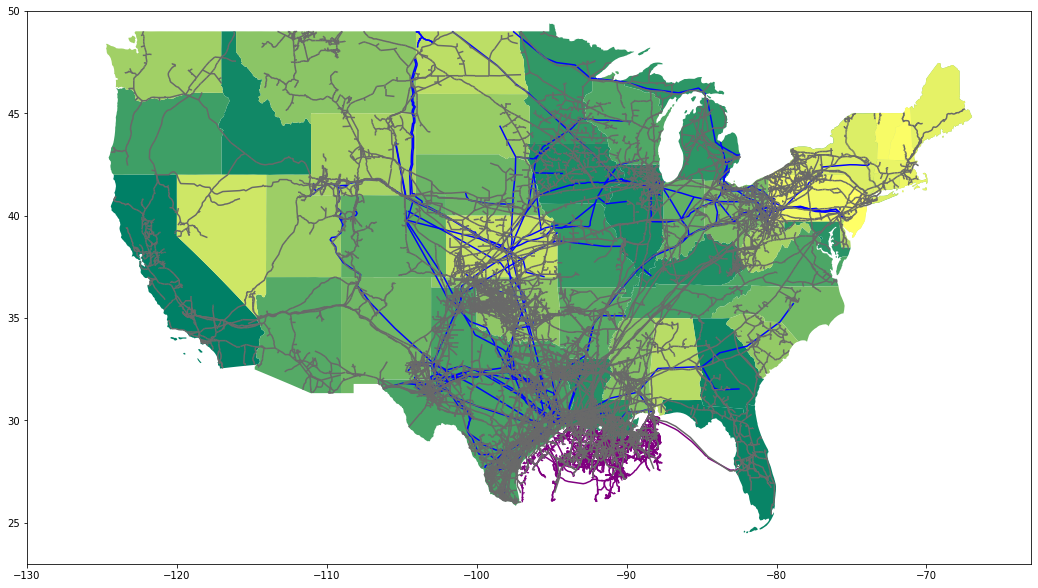

In [170]:
#Putting it all together

states_map = states.plot(cmap='summer', figsize=(18, 81))
#crude_pipe_clipped.plot(ax = states_map, color = 'black')
HGL_trans_pipe_clipped.plot(ax =states_map, color = 'blue')
Gulf_mexico_pipe.plot(ax =states_map, color = 'purple')
#inter_intra_pipe_clipped = geopandas.clip(inter_intra_pipe, states)  #using the clip() function, and clipping the pipeline data to the continental USA boundaries.
inter_intra_pipe.plot(ax = states_map, color = 'dimgrey')

#setting the plot limits instead of geopandas clipping as it is a lot faster

plt.xlim(-130,-63)
plt.ylim(23,50)


Next Step: Reading in the incident data

In [171]:
HGL_trans_accidents = pd.read_csv('data/incident_gas_transmission_gathering_jan2010_present.csv',low_memory=False) #changed encoding by saving as csv file again, tab delimited

pd.options.display.max_rows = 999
HGL_trans_accidents.columns

HGL_trans_accidents.shape

(1521, 625)

The data file we have has so many columns that are not useful, so I have made a .txt file of the columns required for our analysis.

In [172]:
req_clmns = []

with open('data/Gas_Trans_required_columns.txt') as f: #importing the list of required columns form the text file
    lines = f.readlines()
f.close()

for l in lines:
    req_clmns.append(l.strip()) #getting rid of the "\n" escape character



In [173]:
HGL_trans_acc = HGL_trans_accidents[req_clmns]
HGL_trans_acc.info()#stripped down from 625 columns to 61 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   REPORT_RECEIVED_DATE            1521 non-null   object 
 1   IYEAR                           1521 non-null   int64  
 2   REPORT_NUMBER                   1521 non-null   int64  
 3   NAME                            1521 non-null   object 
 4   OPERATOR_STATE_ABBREVIATION     1521 non-null   object 
 5   LOCATION_LATITUDE               1521 non-null   float64
 6   LOCATION_LONGITUDE              1521 non-null   float64
 7   COMMODITY_RELEASED_TYPE         1487 non-null   object 
 8   UNINTENTIONAL_RELEASE           1521 non-null   float64
 9   INTENTIONAL_RELEASE             1446 non-null   float64
 10  ACCOMPANYING_LIQUID             1410 non-null   float64
 11  CAUSE                           1521 non-null   object 
 12  CAUSE_DETAILS                   15

In [174]:
# I have discovered some outliers that fall outside the continental USA, so I will explude those: 
HGL_trans_acc = HGL_trans_acc[(-140<HGL_trans_acc['LOCATION_LONGITUDE']) & (HGL_trans_acc['LOCATION_LONGITUDE']<-50)]
HGL_trans_acc = HGL_trans_acc[HGL_trans_acc['LOCATION_LATITUDE']<50]

HGL_trans_acc.shape

(1512, 61)

In [175]:
HGL_trans_acc.head()

REPORT_RECEIVED_DATE  IYEAR  REPORT_NUMBER  \
0            5/18/2022   2022       20220056   
1            5/13/2022   2022       20220055   
2            5/09/2022   2022       20220054   
3            5/09/2022   2022       20220053   
4            4/27/2022   2022       20220049   

                                     NAME OPERATOR_STATE_ABBREVIATION  \
0            ENABLE GAS TRANSMISSION, LLC                          OK   
1           ARCHAEA ENERGY OPERATING, LLC                          MI   
2  TRANSCONTINENTAL GAS PIPE LINE COMPANY                          OK   
3            ENABLE GAS TRANSMISSION, LLC                          OK   
4        GULF SOUTH PIPELINE COMPANY, LLC                          TX   

   LOCATION_LATITUDE  LOCATION_LONGITUDE COMMODITY_RELEASED_TYPE  \
0          35.296780          -93.429780             NATURAL GAS   
1          35.319820          -97.360050             NATURAL GAS   
2          32.204084          -87.949010             NATURAL GAS   
3          35.691940         -100.227520             NATURAL GAS   
4          32.028480          -90.142318             NATURAL GAS   

   UNINTENTIONAL_RELEASE  INTENTIONAL_RELEASE  ...  EST_COST_EMERGENCY  \
0                  100.0                523.0  ...              1000.0   
1                  961.0                  0.0  ...                 0.0   
2                53185.0               3424.0  ...                 0.0   
3                 6975.0                  0.0  ...              1000.0   
4                 3394.0                  0.0  ...               630.0   

  EST_COST_OTHER EST_COST_OTHER_DETAILS GAS_COST_IN_MCF  \
0            0.0                    NaN            6.59   
1            0.0                    NaN            8.40   
2            0.0       TOTAL COSTS TBD.            4.50   
3            0.0                    NaN            4.90   
4            0.0                    NaN            5.34   

   NUM_PERSONS_HOSP_NOT_OVNGHT  NUM_INJURED_TREATED_BY_EMT  \
0                          0.0                         0.0   
1                          0.0                         1.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   NUM_RESIDENT_BUILDING_AFFCTD  NUM_BUSINESS_BUILDING_AFFCTD  ACCIDENT_PSIG  \
0                           0.0                           0.0          700.0   
1                           0.0                           0.0          160.0   
2                           1.0                           0.0          779.0   
3                           0.0                           0.0          967.0   
4                           0.0                           0.0         1424.0   

   GAS_FLOW_IN_PIPE_IN_MCF  
0                   6000.0  
1                    288.0  
2                  40000.0  
3                   2000.0  
4                   2300.0  

[5 rows x 61 columns]

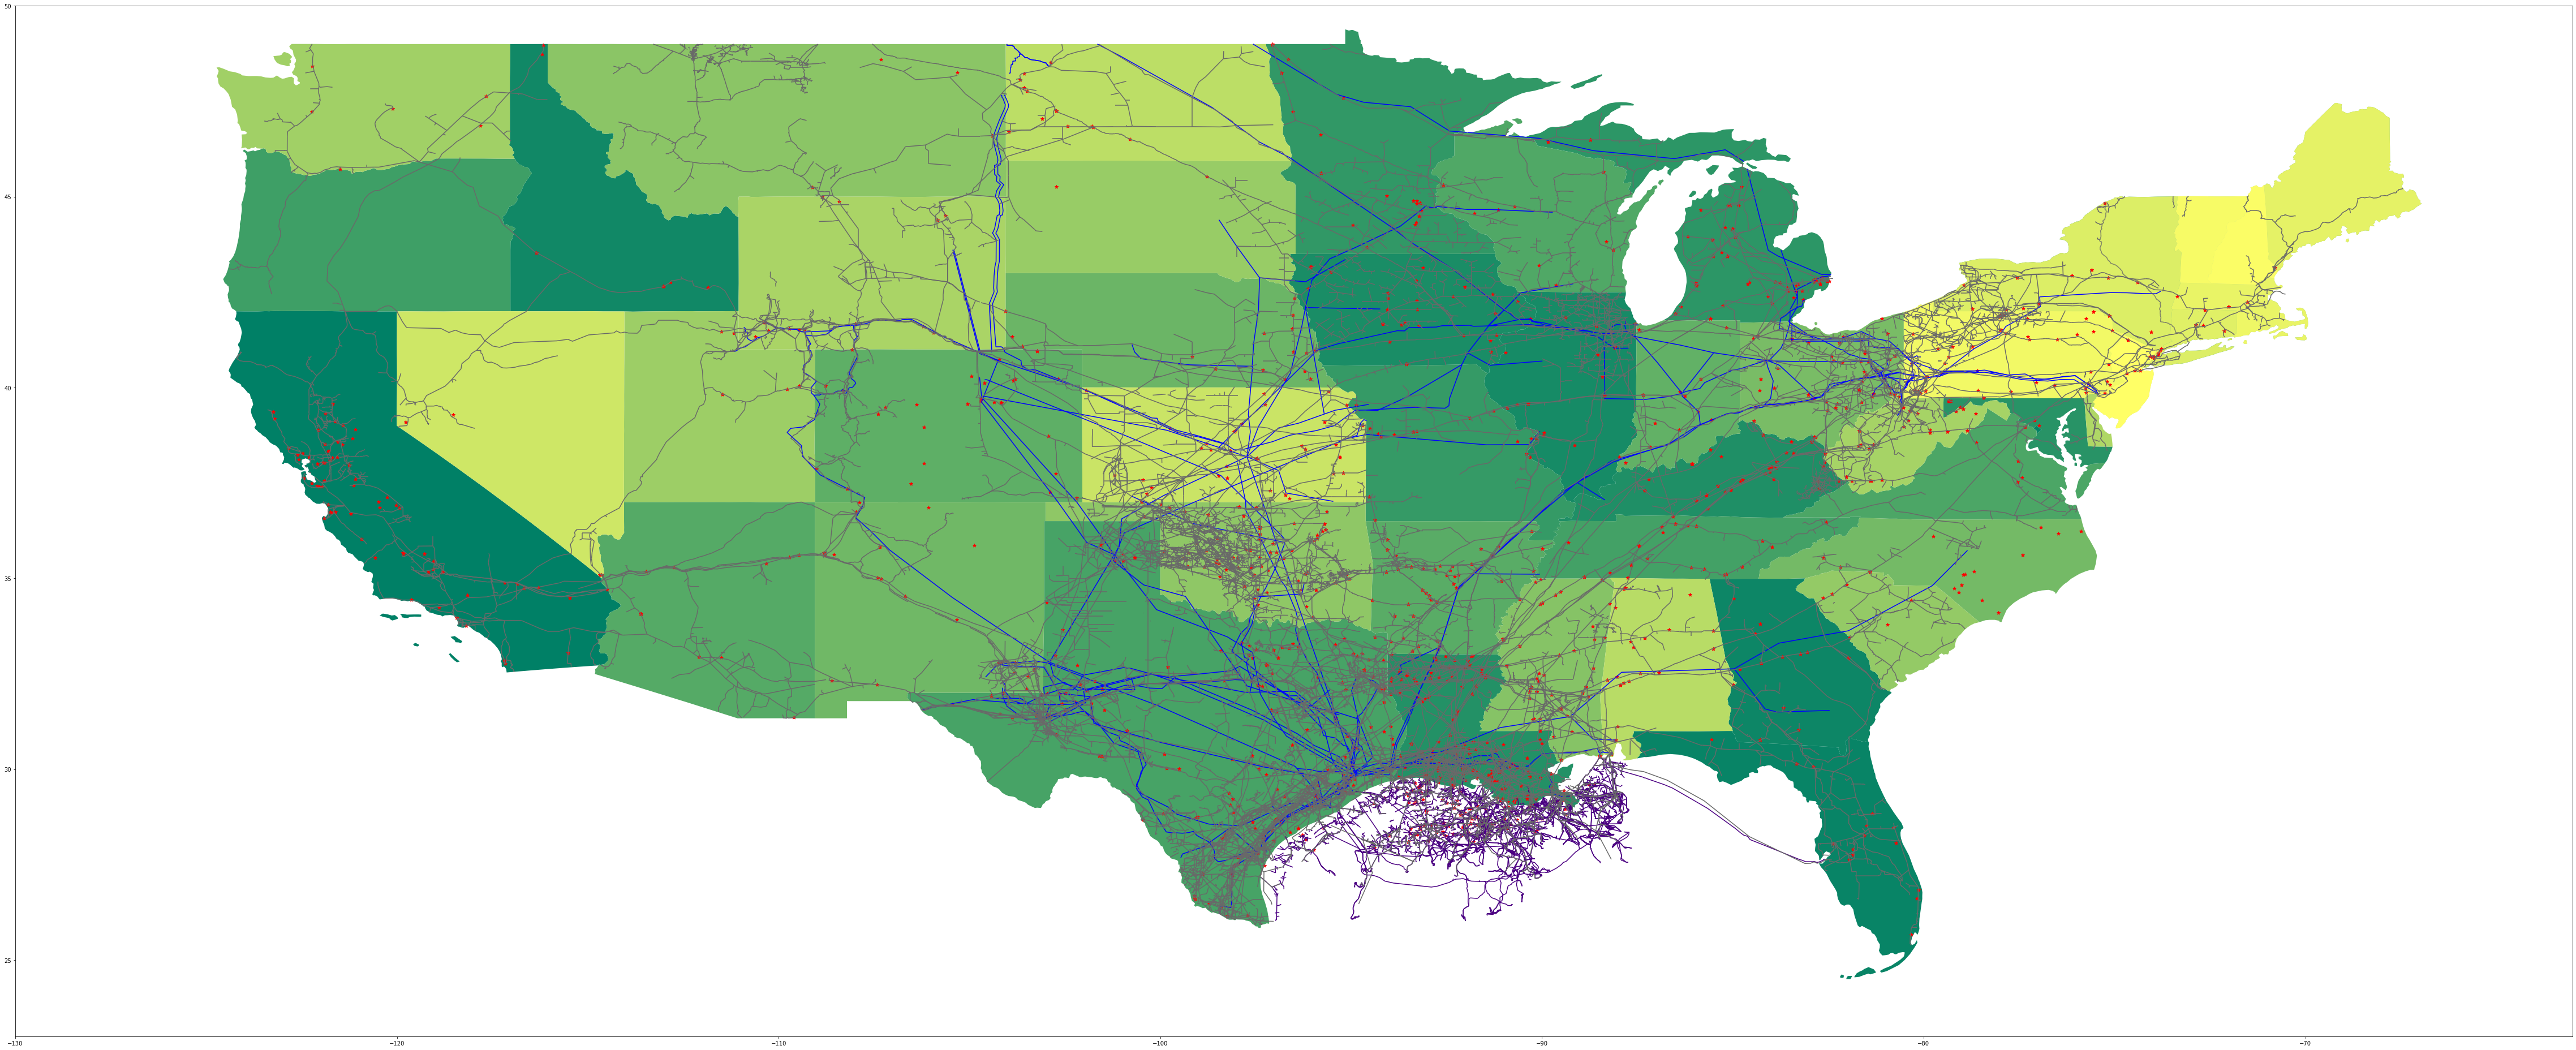

In [176]:
#Putting it all together


states_map = states.plot(cmap='summer', figsize=(81, 60))
#crude_pipe_clipped.plot(ax = states_map, color = 'black')
HGL_trans_pipe_clipped.plot(ax = states_map, color = 'blue')
Gulf_mexico_pipe.plot(ax = states_map, color = 'indigo')

#inter_intra_pipe_clipped = geopandas.clip(inter_intra_pipe, states)  #using the clip() function, and clipping the pipeline data to the continental USA boundaries.
#inter_intra_pipe_clipped.plot(ax = states_map, color = 'dimgrey')
inter_intra_pipe.plot(ax = states_map, color = 'dimgrey')



# Creating lists for lat-long from the dataset
long = HGL_trans_acc['LOCATION_LONGITUDE'].tolist()
lat = HGL_trans_acc['LOCATION_LATITUDE'].tolist()

#geenrating points for the map
geometry = [Point(xy) for xy in zip(long,lat)]

#Putting the generated points in a geopandas dataframe
geo_df = geopandas.GeoDataFrame(geometry = geometry)

#Putting the dots on the map
g = geo_df.plot(ax = states_map, markersize = 40, color = 'red',marker = '*')

#setting the plot limits instead of geopandas clipping as it is a lot faster
plt.xlim(-130,-63)
plt.ylim(23,50)



plt.show()

### Superimposing the incidents on a map using heatmaps by state

In [177]:
HGL_trans_acc.columns

Index(['REPORT_RECEIVED_DATE', 'IYEAR', 'REPORT_NUMBER', 'NAME',
       'OPERATOR_STATE_ABBREVIATION', 'LOCATION_LATITUDE',
       'LOCATION_LONGITUDE', 'COMMODITY_RELEASED_TYPE',
       'UNINTENTIONAL_RELEASE', 'INTENTIONAL_RELEASE', 'ACCOMPANYING_LIQUID',
       'CAUSE', 'CAUSE_DETAILS', 'FATALITY_IND', 'NUM_EMP_FATALITIES',
       'NUM_CONTR_FATALITIES', 'NUM_ER_FATALITIES', 'NUM_WORKER_FATALITIES',
       'NUM_GP_FATALITIES', 'FATAL', 'INJURY_IND', 'NUM_EMP_INJURIES',
       'NUM_CONTR_INJURIES', 'NUM_ER_INJURIES', 'NUM_WORKER_INJURIES',
       'NUM_GP_INJURIES', 'INJURE', 'GAS_CONSUMED_BY_FIRE_IN_MCF',
       'EXPLODE_IND', 'INCIDENT_AREA_TYPE', 'SYSTEM_PART_INVOLVED',
       'INSTALLATION_YEAR', 'ITEM_INVOLVED', 'PIPE_TYPE', 'PIPE_DIAMETER',
       'PIPE_WALL_THICKNESS', 'PIPE_SMYS', 'PIPE_SPECIFICATION',
       'PIPE_SEAM_TYPE', 'PIPE_MANUFACTURER', 'PIPE_COATING_TYPE',
       'PIPE_COATING_DETAILS', 'COATING_APPLIED_IND', 'MATERIAL_INVOLVED',
       'RELEASE_TYPE', 'LEAK_TYPE',

In [178]:
HGL_trans_acc.head()

REPORT_RECEIVED_DATE  IYEAR  REPORT_NUMBER  \
0            5/18/2022   2022       20220056   
1            5/13/2022   2022       20220055   
2            5/09/2022   2022       20220054   
3            5/09/2022   2022       20220053   
4            4/27/2022   2022       20220049   

                                     NAME OPERATOR_STATE_ABBREVIATION  \
0            ENABLE GAS TRANSMISSION, LLC                          OK   
1           ARCHAEA ENERGY OPERATING, LLC                          MI   
2  TRANSCONTINENTAL GAS PIPE LINE COMPANY                          OK   
3            ENABLE GAS TRANSMISSION, LLC                          OK   
4        GULF SOUTH PIPELINE COMPANY, LLC                          TX   

   LOCATION_LATITUDE  LOCATION_LONGITUDE COMMODITY_RELEASED_TYPE  \
0          35.296780          -93.429780             NATURAL GAS   
1          35.319820          -97.360050             NATURAL GAS   
2          32.204084          -87.949010             NATURAL GAS   
3          35.691940         -100.227520             NATURAL GAS   
4          32.028480          -90.142318             NATURAL GAS   

   UNINTENTIONAL_RELEASE  INTENTIONAL_RELEASE  ...  EST_COST_EMERGENCY  \
0                  100.0                523.0  ...              1000.0   
1                  961.0                  0.0  ...                 0.0   
2                53185.0               3424.0  ...                 0.0   
3                 6975.0                  0.0  ...              1000.0   
4                 3394.0                  0.0  ...               630.0   

  EST_COST_OTHER EST_COST_OTHER_DETAILS GAS_COST_IN_MCF  \
0            0.0                    NaN            6.59   
1            0.0                    NaN            8.40   
2            0.0       TOTAL COSTS TBD.            4.50   
3            0.0                    NaN            4.90   
4            0.0                    NaN            5.34   

   NUM_PERSONS_HOSP_NOT_OVNGHT  NUM_INJURED_TREATED_BY_EMT  \
0                          0.0                         0.0   
1                          0.0                         1.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   NUM_RESIDENT_BUILDING_AFFCTD  NUM_BUSINESS_BUILDING_AFFCTD  ACCIDENT_PSIG  \
0                           0.0                           0.0          700.0   
1                           0.0                           0.0          160.0   
2                           1.0                           0.0          779.0   
3                           0.0                           0.0          967.0   
4                           0.0                           0.0         1424.0   

   GAS_FLOW_IN_PIPE_IN_MCF  
0                   6000.0  
1                    288.0  
2                  40000.0  
3                   2000.0  
4                   2300.0  

[5 rows x 61 columns]

In [179]:
grouped_state = HGL_trans_acc.groupby(['OPERATOR_STATE_ABBREVIATION']).count()

In [180]:
grouped_state.head()

REPORT_RECEIVED_DATE  IYEAR  REPORT_NUMBER  NAME  \
OPERATOR_STATE_ABBREVIATION                                                     
AL                                              8      8              8     8   
AR                                              1      1              1     1   
CA                                             72     72             72    72   
CO                                             23     23             23    23   
CT                                              3      3              3     3   

                             LOCATION_LATITUDE  LOCATION_LONGITUDE  \
OPERATOR_STATE_ABBREVIATION                                          
AL                                           8                   8   
AR                                           1                   1   
CA                                          72                  72   
CO                                          23                  23   
CT                                           3                   3   

                             COMMODITY_RELEASED_TYPE  UNINTENTIONAL_RELEASE  \
OPERATOR_STATE_ABBREVIATION                                                   
AL                                                 8                      8   
AR                                                 1                      1   
CA                                                70                     72   
CO                                                23                     23   
CT                                                 3                      3   

                             INTENTIONAL_RELEASE  ACCOMPANYING_LIQUID  ...  \
OPERATOR_STATE_ABBREVIATION                                            ...   
AL                                             8                    7  ...   
AR                                             1                    1  ...   
CA                                            62                   58  ...   
CO                                            23                   22  ...   
CT                                             2                    2  ...   

                             EST_COST_EMERGENCY  EST_COST_OTHER  \
OPERATOR_STATE_ABBREVIATION                                       
AL                                            7               7   
AR                                            1               1   
CA                                           72              72   
CO                                           23              23   
CT                                            3               3   

                             EST_COST_OTHER_DETAILS  GAS_COST_IN_MCF  \
OPERATOR_STATE_ABBREVIATION                                            
AL                                                1                1   
AR                                                0                0   
CA                                                8                7   
CO                                                9                6   
CT                                                0                0   

                             NUM_PERSONS_HOSP_NOT_OVNGHT  \
OPERATOR_STATE_ABBREVIATION                                
AL                                                     1   
AR                                                     0   
CA                                                     7   
CO                                                     6   
CT                                                     0   

                             NUM_INJURED_TREATED_BY_EMT  \
OPERATOR_STATE_ABBREVIATION                               
AL                                                    1   
AR                                                    0   
CA                                                    7   
CO                                                    6   
CT                                                    0   

                             NUM_RESIDENT_BUILDING_AFFCTD  

In [181]:
acc_state = grouped_state['REPORT_RECEIVED_DATE'].to_frame().reset_index()

#creating a data frame as the output of the groupby. The product of the groupby is a series, 
# so you do a to_frame to get the df and then reset the index to get a proper index

acc_state.rename(columns = {'REPORT_RECEIVED_DATE' : 'Incident_count','OPERATOR_STATE_ABBREVIATION' : 'State'}, inplace = True)
# acc_state
acc_state.sample(5)

State  Incident_count
21    NM               2
28    SD               1
2     CA              72
1     AR               1
9     IL               9

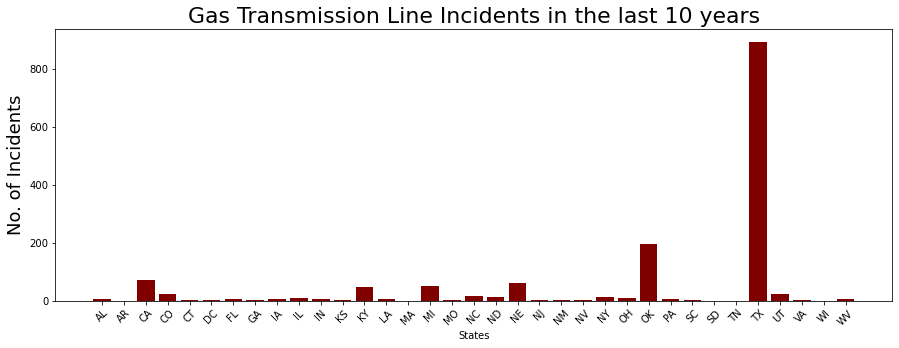

In [182]:

figure(figsize=(15,5))



# creating the bar plot
plt.bar(acc_state.State,acc_state.Incident_count , color ='maroon')
 
plt.xlabel("States")
plt.xticks(rotation = 45)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Transmission Line Incidents in the last 10 years", fontsize = 22)

plt.show()

In [183]:
acc_year = HGL_trans_acc.groupby(['IYEAR']).count().reset_index()
acc_year.rename(columns = {'REPORT_RECEIVED_DATE':'Incident_count'}, inplace=True)
acc_year.sample(5)

IYEAR  Incident_count  REPORT_NUMBER  NAME  OPERATOR_STATE_ABBREVIATION  \
2    2012             115            115   115                          115   
4    2014             139            139   139                          139   
1    2011             128            128   128                          128   
11   2021             109            109   109                          109   
3    2013             112            112   112                          112   

    LOCATION_LATITUDE  LOCATION_LONGITUDE  COMMODITY_RELEASED_TYPE  \
2                 115                 115                      107   
4                 139                 139                      135   
1                 128                 128                      126   
11                109                 109                      109   
3                 112                 112                      107   

    UNINTENTIONAL_RELEASE  INTENTIONAL_RELEASE  ...  EST_COST_EMERGENCY  \
2                     115                   96  ...                 115   
4                     139                  136  ...                 139   
1                     128                  112  ...                 128   
11                    109                  109  ...                 109   
3                     112                   96  ...                 112   

    EST_COST_OTHER  EST_COST_OTHER_DETAILS  GAS_COST_IN_MCF  \
2              115                      19                1   
4              139                      25                1   
1              128                      34                0   
11             109                      28              109   
3              112                      21                1   

    NUM_PERSONS_HOSP_NOT_OVNGHT  NUM_INJURED_TREATED_BY_EMT  \
2                             1                           1   
4                             1                           1   
1                             0                           0   
11                          109                         109   
3                             1                           1   

    NUM_RESIDENT_BUILDING_AFFCTD  NUM_BUSINESS_BUILDING_AFFCTD  ACCIDENT_PSIG  \
2                              1                             1            115   
4                              1                             1            139   
1                              0                             0            128   
11                           109                           109            109   
3                              1                             1            112   

    GAS_FLOW_IN_PIPE_IN_MCF  
2                         1  
4                         1  
1                         0  
11                      109  
3                         1  

[5 rows x 61 columns]

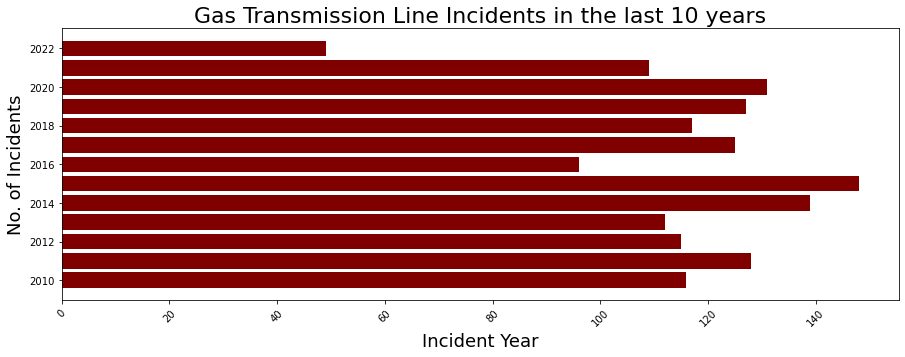

In [196]:

figure(figsize=(15,5))

# creating the bar plot
plt.barh(acc_year.IYEAR,acc_year.Incident_count , color ='maroon')
 
plt.xlabel("Incident Year",fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Transmission Line Incidents in the last 10 years", fontsize = 22)

plt.show()

Having a look at the Injuries, Fatalities and Cuases of the transmission incidents

In [185]:
print('The fatality count is:')
print(HGL_trans_acc['FATAL'].value_counts())
print("\n")
print('The injury count is:')
print(HGL_trans_acc['INJURE'].value_counts())

The fatality count is:
0    1495
1      11
2       4
4       1
8       1
Name: FATAL, dtype: int64


The injury count is:
0     1479
1       22
2        5
4        2
6        1
13       1
51       1
7        1
Name: INJURE, dtype: int64


In [186]:
Acc_Cause = HGL_trans_acc['CAUSE'].value_counts().to_frame().reset_index()
Acc_Cause.rename(columns = {'index':'Cause','CAUSE':'Num_Acc'}, inplace = True)
Acc_Cause

Cause  Num_Acc
0                 EQUIPMENT FAILURE      510
1                 CORROSION FAILURE      287
2                 EXCAVATION DAMAGE      177
3  MATERIAL FAILURE OF PIPE OR WELD      163
4              NATURAL FORCE DAMAGE      112
5               INCORRECT OPERATION      100
6        OTHER OUTSIDE FORCE DAMAGE       95
7              OTHER INCIDENT CAUSE       68

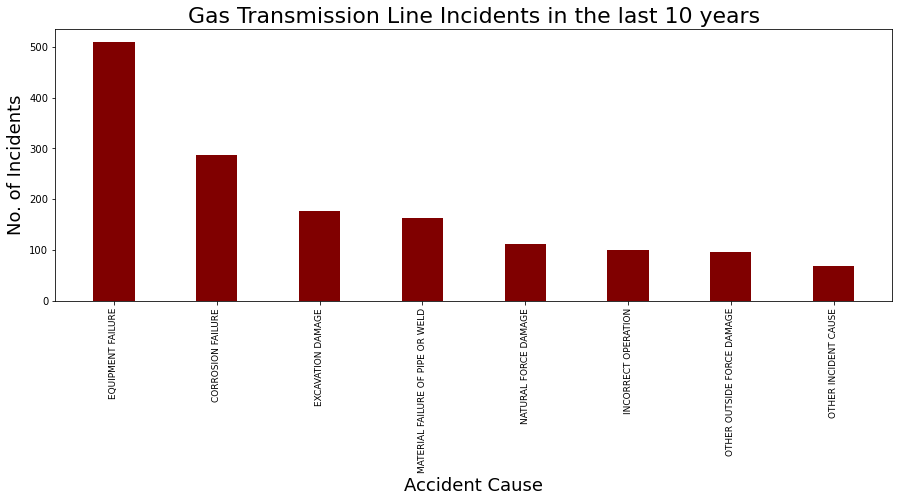

In [187]:
figure(figsize=(15,5))

# creating the bar plot
plt.bar(Acc_Cause['Cause'],Acc_Cause['Num_Acc'] , color ='maroon', width = 0.4)
 
plt.xlabel("Accident Cause",fontsize = 18)
plt.xticks(rotation = 90, fontsize = 9)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Transmission Line Incidents in the last 10 years", fontsize = 22)

plt.show()

In [188]:
Acc_SubCause = HGL_trans_acc['CAUSE_DETAILS'].value_counts().to_frame().reset_index()
Acc_SubCause.rename(columns = {'index':'SubCause','CAUSE_DETAILS':'Num_Acc'}, inplace = True)
Acc_SubCause_top10 = Acc_SubCause[0:10]
Acc_SubCause_top10

SubCause  Num_Acc
0            MALFUNCTION OF CONTROL/RELIEF EQUIPMENT      318
1                                 INTERNAL CORROSION      183
2                   EXCAVATION DAMAGE BY THIRD PARTY      132
3                                 EXTERNAL CORROSION      104
4  DESIGN-, CONSTRUCTION-, INSTALLATION-, OR FABR...       97
5               THREADED CONNECTION/COUPLING FAILURE       56
6                         OTHER INCORRECT OPERATION        49
7  DAMAGE BY CAR, TRUCK, OR OTHER MOTORIZED VEHIC...       46
8                            OTHER EQUIPMENT FAILURE       43
9  ORIGINAL MANUFACTURING-RELATED (NOT GIRTH WELD...       39

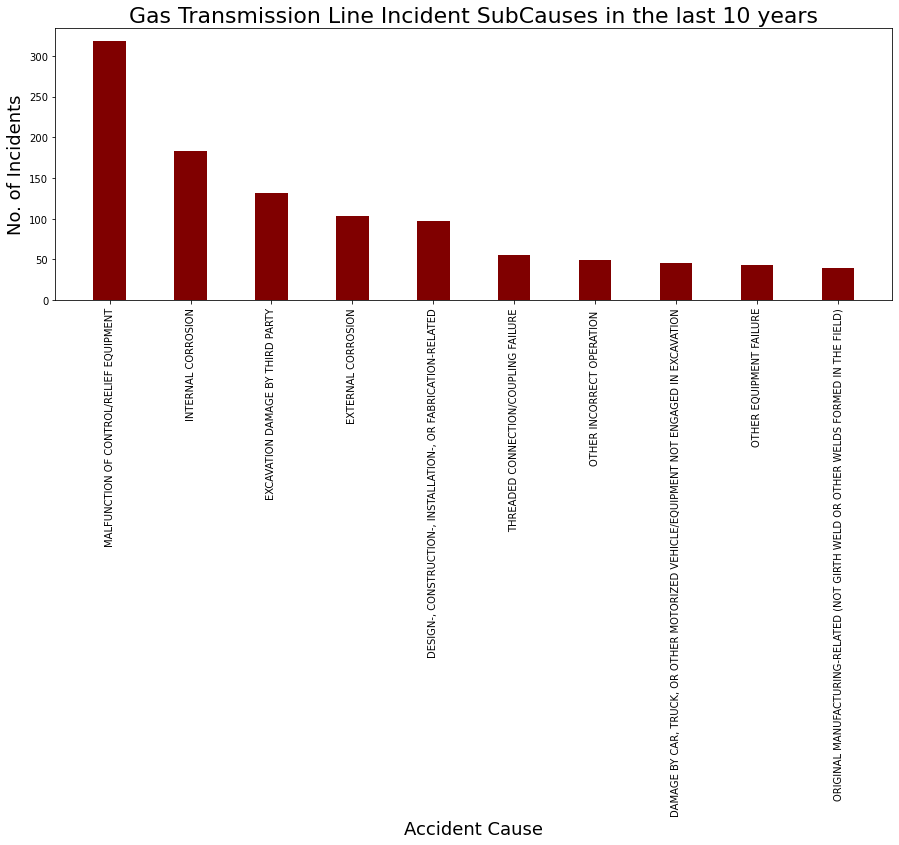

In [189]:
figure(figsize=(15,5))

# creating the bar plot
plt.bar(Acc_SubCause_top10['SubCause'],Acc_SubCause_top10['Num_Acc'] , color ='maroon', width = 0.4)
 
plt.xlabel("Accident Cause",fontsize = 18)
plt.xticks(rotation = 90)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Transmission Line Incident SubCauses in the last 10 years", fontsize = 22)

plt.show()

# THEN DO THE SAME THING FOR THE GAS DISTRIBUTION INCIDENTS TOO!
# (We have only done it for transmission and interstate/intrastate lines)

In [190]:
# Working on Gas Distribution Accidents now:

Gas_Dist_Accidents = pd.read_csv('data/incident_gas_distribution_jan2010_present.csv',low_memory=False) #changed encoding by saving as csv file again, tab delimited

Gas_Dist_Accidents.head()


REPORT_RECEIVED_DATE  IYEAR  REPORT_NUMBER  SUPPLEMENTAL_NUMBER  \
0            3/25/2022   2022       20220023                36499   
1            3/25/2022   2022       20220024                36500   
2            3/03/2022   2022       20220019                36417   
3            3/08/2022   2022       20220022                36437   
4            3/04/2022   2022       20220020                36425   

      REPORT_TYPE  OPERATOR_ID                                NAME  \
0  ORIGINAL FINAL        22182             WASHINGTON GAS LIGHT CO   
1        ORIGINAL         2748                 CONSUMERS ENERGY CO   
2  ORIGINAL FINAL        15518         PIEDMONT NATURAL GAS CO INC   
3  ORIGINAL FINAL        31348  ATMOS ENERGY CORPORATION - MID-TEX   
4        ORIGINAL         1800   KEYSPAN ENERGY DELIVERY - NY CITY   

       OPERATOR_STREET_ADDRESS OPERATOR_CITY_NAME OPERATOR_STATE_ABBREVIATION  \
0       1000 MAINE AVENUE, SW          WASHINGTON                          DC   
1            ONE ENERGY PLAZA             JACKSON                          MI   
2       4720 PIEDMONT ROW DR.           CHARLOTTE                          NC   
3  5430 LBJ FREEWAY SUITE 1800             DALLAS                          TX   
4               40 SYLVAN RD.             WALTHAM                          MA   

   ... PREPARER_TELEPHONE PREPARER_FAX LOCAL_CONTACT_NAME  \
0  ...         7037505921          NaN         MARK AIESI   
1  ...       989-280-2963          NaN      CARMELLA KING   
2  ...       704-731-4680          NaN                NaN   
3  ...       512-844-8270          NaN                NaN   
4  ...         5169030596          NaN     CORINNE BYRNES   

               LOCAL_CONTACT_EMAIL LOCAL_CONTACT_TELEPHONE  \
0           mark.aiesi@washgas.com              7037505216   
1      carmella.king@cmsenergy.com            989-280-2963   
2                              NaN                     NaN   
3                              NaN                     NaN   
4  corinne.byrnes@nationalgrid.com              5169030596   

      AUTHORIZER_NAME                            AUTHORIZER_TITLE  \
0  SHANNON B. MALONEY  MANAGER DOT PIPELINE SAFETY AND COMPLIANCE   
1         JASON PIONK                      GAS COMPLIANCE MANAGER   
2        FARRIS BERRY                     PIPELINE SAFETY MANAGER   
3        MARLO SUTTON           VICE PRESIDENT TECHNICAL SERVICES   
4      CORINNE BYRNES             PRIN PROGRAM MGR REGULATORY MOC   

  AUTHORIZER_TELEPHONE                 AUTHORIZER_EMAIL  \
0           7037505558             smaloney@washgas.com   
1         989-791-5749        jason.pionk@cmsenergy.com   
2         704-731-4618     farris.berry@duke-energy.com   
3         214-957-3295     marlo.sutton@atmosenergy.com   
4           5169030596  corinne.byrnes@nationalgrid.com   

                                           NARRATIVE  
0  ON MARCH 3, 2022 AT 11:07HRS WASHINGTON GAS WA...  
1  ON TUESDAY, FEBRUARY 8, 2022 AT APPROXIMATELY ...  
2  WATER COMPANY TAPPED A 8" HIGH PRESSURE STEEL ...  
3  AT 07:45 ON FEBRUARY 8, 2022, A THIRD PARTY CO...  
4  NATIONAL GRID DISPATCH WAS NOTIFIED ON 02/04/2...  

[5 rows x 466 columns]

In [191]:
Gas_Dist_Accidents.columns

req_clmns = req_clmns = []

with open('data/Gas_Dist_required_columns.txt') as f: #importing the list of required columns form the text file
    lines = f.readlines()
f.close()

for l in lines:
    req_clmns.append(l.strip()) #getting rid of the "\n" escape character

Gas_Dist_Acc = Gas_Dist_Accidents[req_clmns]

Gas_Dist_Acc.shape

(1314, 51)

Extracting the lat=long cordinates to superimpose this on a map

In [192]:
Gas_Dist_Acc.sample(5)

REPORT_RECEIVED_DATE  IYEAR                                NAME  \
935             6/21/2013   2013                 AMERIGAS PROPANE LP   
715             8/06/2015   2015     PEOPLES NATURAL GAS COMPANY LLC   
347             2/22/2019   2019  ATMOS ENERGY CORPORATION - MID-TEX   
1013           10/03/2012   2012          SOUTHERN CALIFORNIA GAS CO   
832             8/20/2014   2014                     DTE GAS COMPANY   

        LOCATION_STREET_ADDRESS LOCATION_CITY_NAME LOCATION_COUNTY_NAME  \
935              MERRIDIAN BLVD      MAMMOTH LAKES                  NaN   
715   1215 AND 1217 REBECCA AVE     NORTH BRADDOCK            ALLEGHANY   
347           CR 4235 & CR 4270          RHINELAND                 KNOX   
1013        11412 VENTURA BLVD.        STUDIO CITY          LOS ANGELES   
832                  1809 EDSON        HUDSONVILLE               OTTAWA   

     LOCATION_STATE_ABBREVIATION LOCATION_POSTAL_CODE  LOCATION_LATITUDE  \
935                           CA                93546          37.660740   
715                           PA                15104          40.399639   
347                           TX                76371          33.498349   
1013                          CA                91604          34.139668   
832                           MI                49426          42.882085   

      LOCATION_LONGITUDE  ... CLASS_LOCATION_TYPE  EST_COST_OPER_PAID  \
935          -118.888440  ...    CLASS 2 LOCATION                 0.0   
715           -79.858406  ...    CLASS 3 LOCATION             47400.0   
347           -99.687506  ...    CLASS 1 LOCATION                 0.0   
1013         -118.379288  ...    CLASS 3 LOCATION             10000.0   
832           -85.829144  ...    CLASS 3 LOCATION                 0.0   

      EST_COST_PROP_DAMAGE EST_COST_EMERGENCY  EST_COST_OTHER  \
935                 2500.0             1000.0             0.0   
715                    0.0             7100.0             0.0   
347                11740.0             2000.0             0.0   
1013                3000.0              400.0             0.0   
832                69970.0             5760.0         11520.0   

      GAS_COST_IN_MCF  EST_COST_UNINTENTIONAL_RELEASE  \
935               NaN                           275.0   
715               NaN                             8.0   
347               NaN                         24268.0   
1013              NaN                           125.0   
832               NaN                             0.0   

      EST_COST_INTENTIONAL_RELEASE  \
935                            NaN   
715                            NaN   
347                            NaN   
1013                           NaN   
832                            NaN   

                                          CAUSE_DETAILS  \
935                    EXCAVATION DAMAGE BY THIRD PARTY   
715                                       MISCELLANEOUS   
347                    EXCAVATION DAMAGE BY THIRD PARTY   
1013  DAMAGE BY CAR, TRUCK, OR OTHER MOTORIZED VEHIC...   
832             MALFUNCTION OF CONTROL/RELIEF EQUIPMENT   

                           CAUSE  
935            EXCAVATION DAMAGE  
715         OTHER INCIDENT CAUSE  
347            EXCAVATION DAMAGE  
1013  OTHER OUTSIDE FORCE DAMAGE  
832            EQUIPMENT FAILURE  

[5 rows x 51 columns]

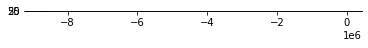

In [198]:
#states_map =  states.boundary.plot(figsize=(40, 20),  color="#555555", linewidth=1)
#states_map.axis('off')


# Creating lists for lat-long from the dataset
long = Gas_Dist_Acc['LOCATION_LONGITUDE']
lat = Gas_Dist_Acc['LOCATION_LATITUDE']

#geenrating points for the map
geometry = [Point(xy) for xy in zip(long,lat)]

#Putting the generated points in a geopandas dataframe
geo_df = geopandas.GeoDataFrame(geometry = geometry)

#Putting the dots on the map
g = geo_df.plot( markersize = 40, color = 'red',marker = '*')



<AxesSubplot:>

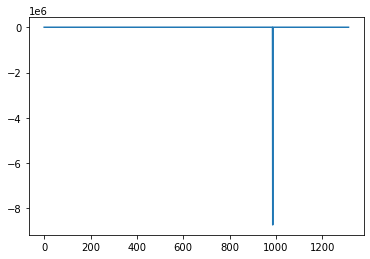

In [199]:
long.plot()

<AxesSubplot:>

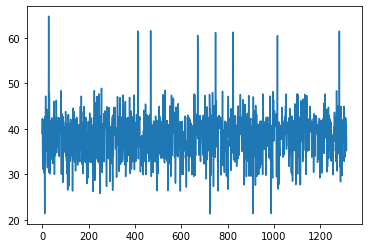

In [200]:
lat.plot()

There is an outlier in the longitude column, so we find it and drop that whole row so we can do the plotting 

In [201]:
drop_row_index = Gas_Dist_Acc['LOCATION_LONGITUDE'].idxmin() #getting the row index for the minimum oulier 
drop_row_index

986

In [202]:
Gas_Dist_Acc.drop(Gas_Dist_Acc.index[drop_row_index], inplace = True)

C:\Users\Ramin\AppData\Local\Temp\ipykernel_13168\709994726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gas_Dist_Acc.drop(Gas_Dist_Acc.index[drop_row_index], inplace = True)


In [203]:
Gas_Dist_Acc.shape #So we dropped one row

(1313, 51)

Lets try plotting the incident locations again

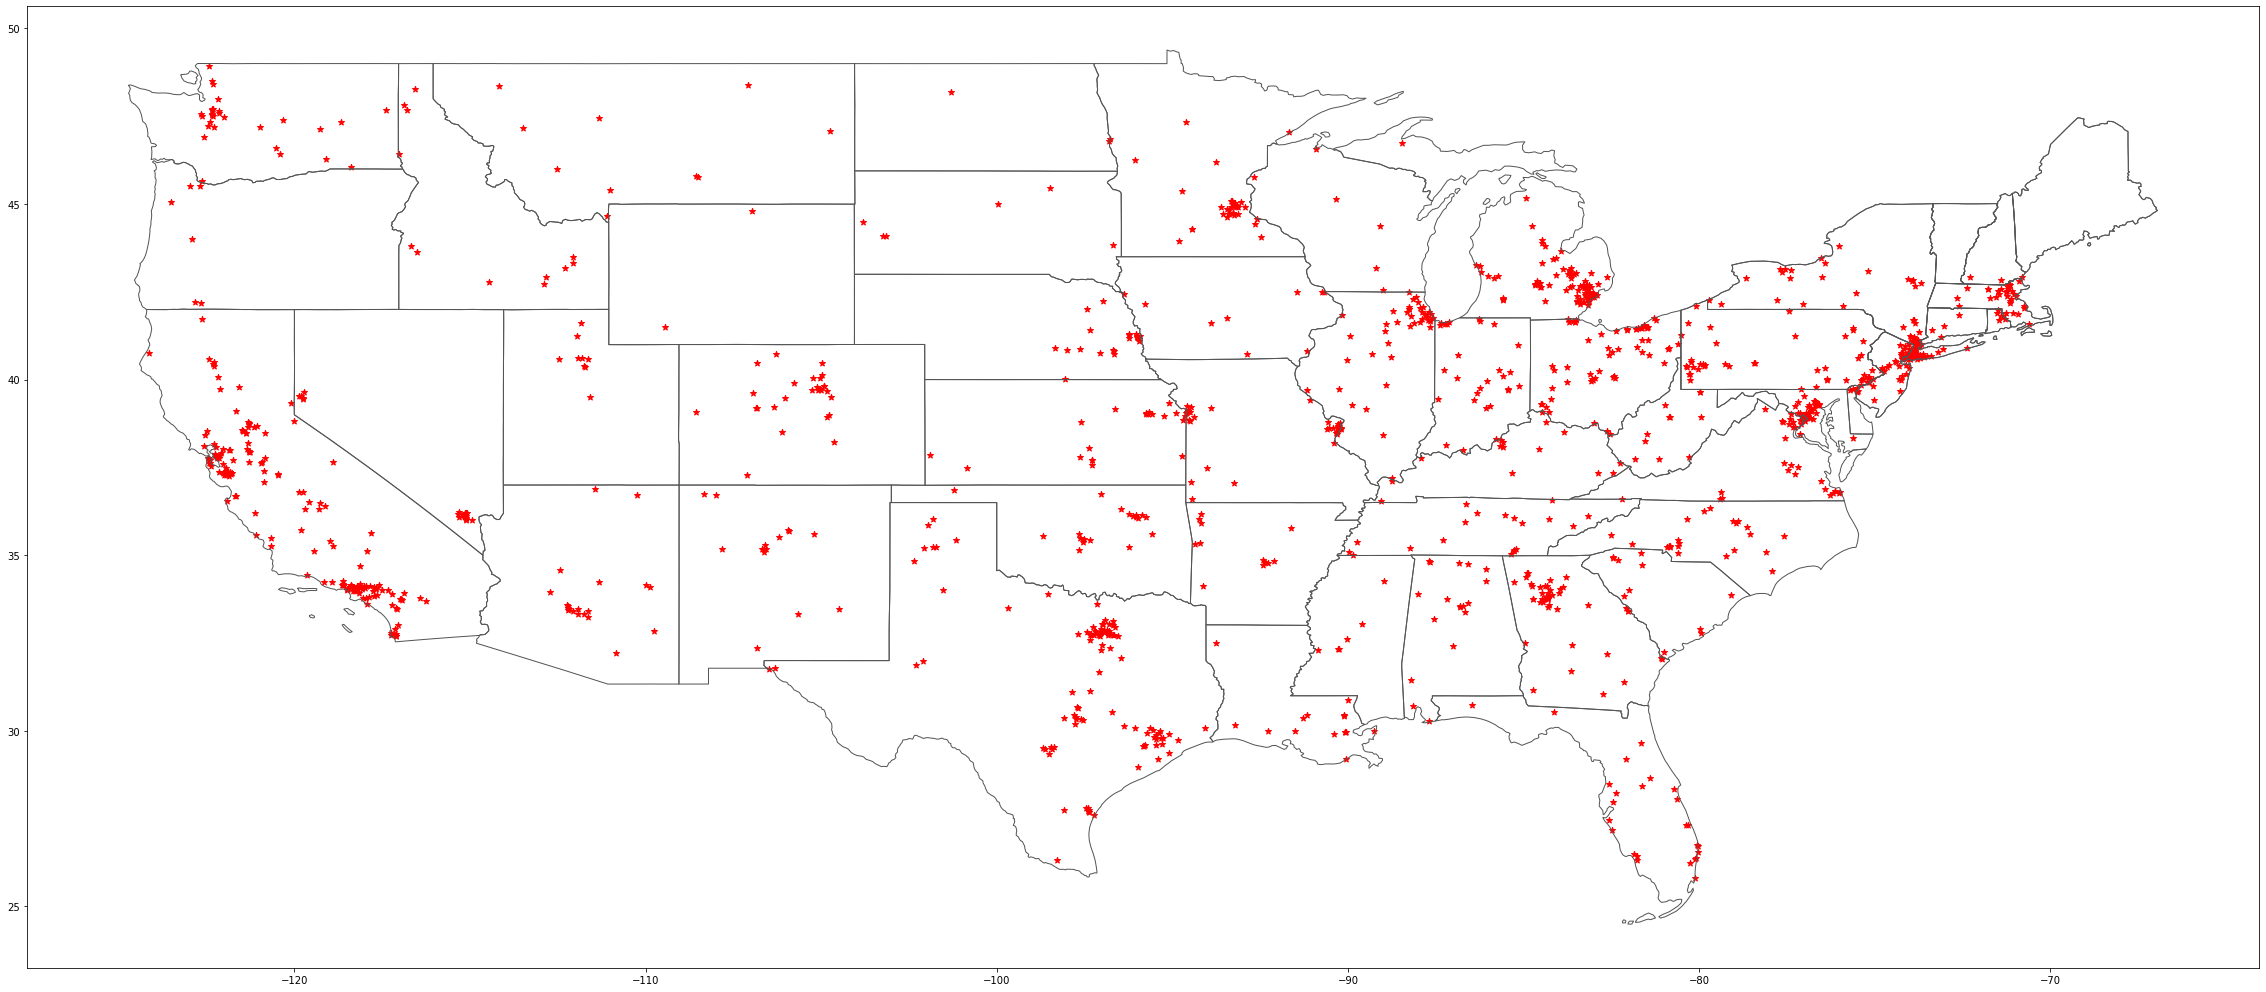

In [204]:
states_map =  states.boundary.plot(figsize=(40, 20),  color="#555555", linewidth=1)
#states_map.axis('off')

# I have discovered some outliers that fall outside the continental USA, so I will explude those: 
Gas_Dist_Acc = Gas_Dist_Acc[(-140<Gas_Dist_Acc['LOCATION_LONGITUDE']) & (Gas_Dist_Acc['LOCATION_LONGITUDE']<-50)]
Gas_Dist_Acc = Gas_Dist_Acc[Gas_Dist_Acc['LOCATION_LATITUDE']<50]


# Creating lists for lat-long from the dataset
long = Gas_Dist_Acc['LOCATION_LONGITUDE'].tolist()
lat = Gas_Dist_Acc['LOCATION_LATITUDE'].tolist()

#geenrating points for the map
geometry = [Point(xy) for xy in zip(long,lat)]

#Putting the generated points in a geopandas dataframe
geo_df = geopandas.GeoDataFrame(geometry = geometry)

#Putting the dots on the map
g = geo_df.plot( ax = states_map, markersize = 40, color = 'red',marker = '*')

plt.show()

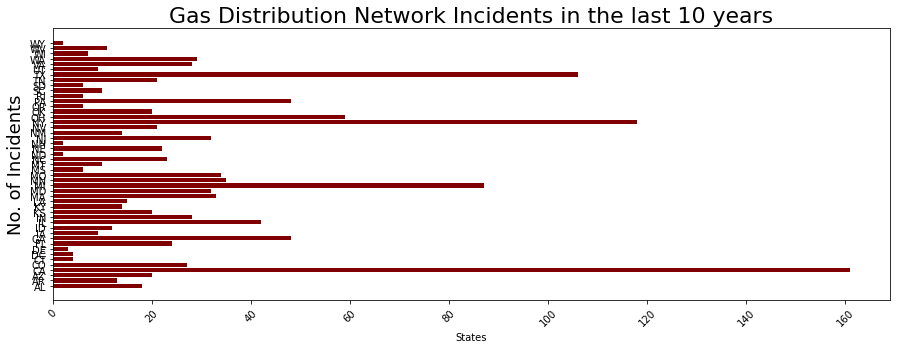

In [212]:
grouped_state = Gas_Dist_Acc.groupby(['LOCATION_STATE_ABBREVIATION']).count()
acc_state = grouped_state['REPORT_RECEIVED_DATE'].to_frame().reset_index()

#creating a data frame as the output of the groupby. The product of the groupby is a series, 
# so you do a to_frame to get the df and then reset the index to get a proper index

acc_state.rename(columns = {'REPORT_RECEIVED_DATE' : 'Incident_count','LOCATION_STATE_ABBREVIATION' : 'State'}, inplace = True)
# acc_state

figure(figsize=(15,5))
# creating the bar plot
plt.barh(acc_state.State, acc_state.Incident_count, color ='maroon')
 
plt.xlabel("States")
plt.xticks(rotation = 45)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Distribution Network Incidents in the last 10 years", fontsize = 22)

plt.show()

So in the geopandas states data frame the state abbreviation is 'STUSPS'. In the acc_state (accident by state) dataframe we have made, the state abbreviation is: Satates, 
we can merge these two and replace any NaN with zero for our heatmap.
I got the instructions from here: https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55

In [206]:
#joining the shape file with the incident data file
merged = states.set_index('STUSPS').join(acc_state.set_index('State'))
merged = merged.reset_index()
merged = merged.fillna(0)
merged.rename(columns={'index':'State'}, inplace=True)

## Taking Texas and Oklahoma out of the maps to se more data
#merged = merged.loc[(merged["State"] != 'TX')&(merged["State"] != 'OK')] 

merged[['State','Incident_count']].sample(5)

State  Incident_count
26    MS             6.0
1     AR            13.0
47    SD             6.0
30    NE            22.0
39    OH            59.0

<AxesSubplot:title={'center':'Heat Map of Gas Distribution Incidents in the Last 10 Years Across the United States'}>

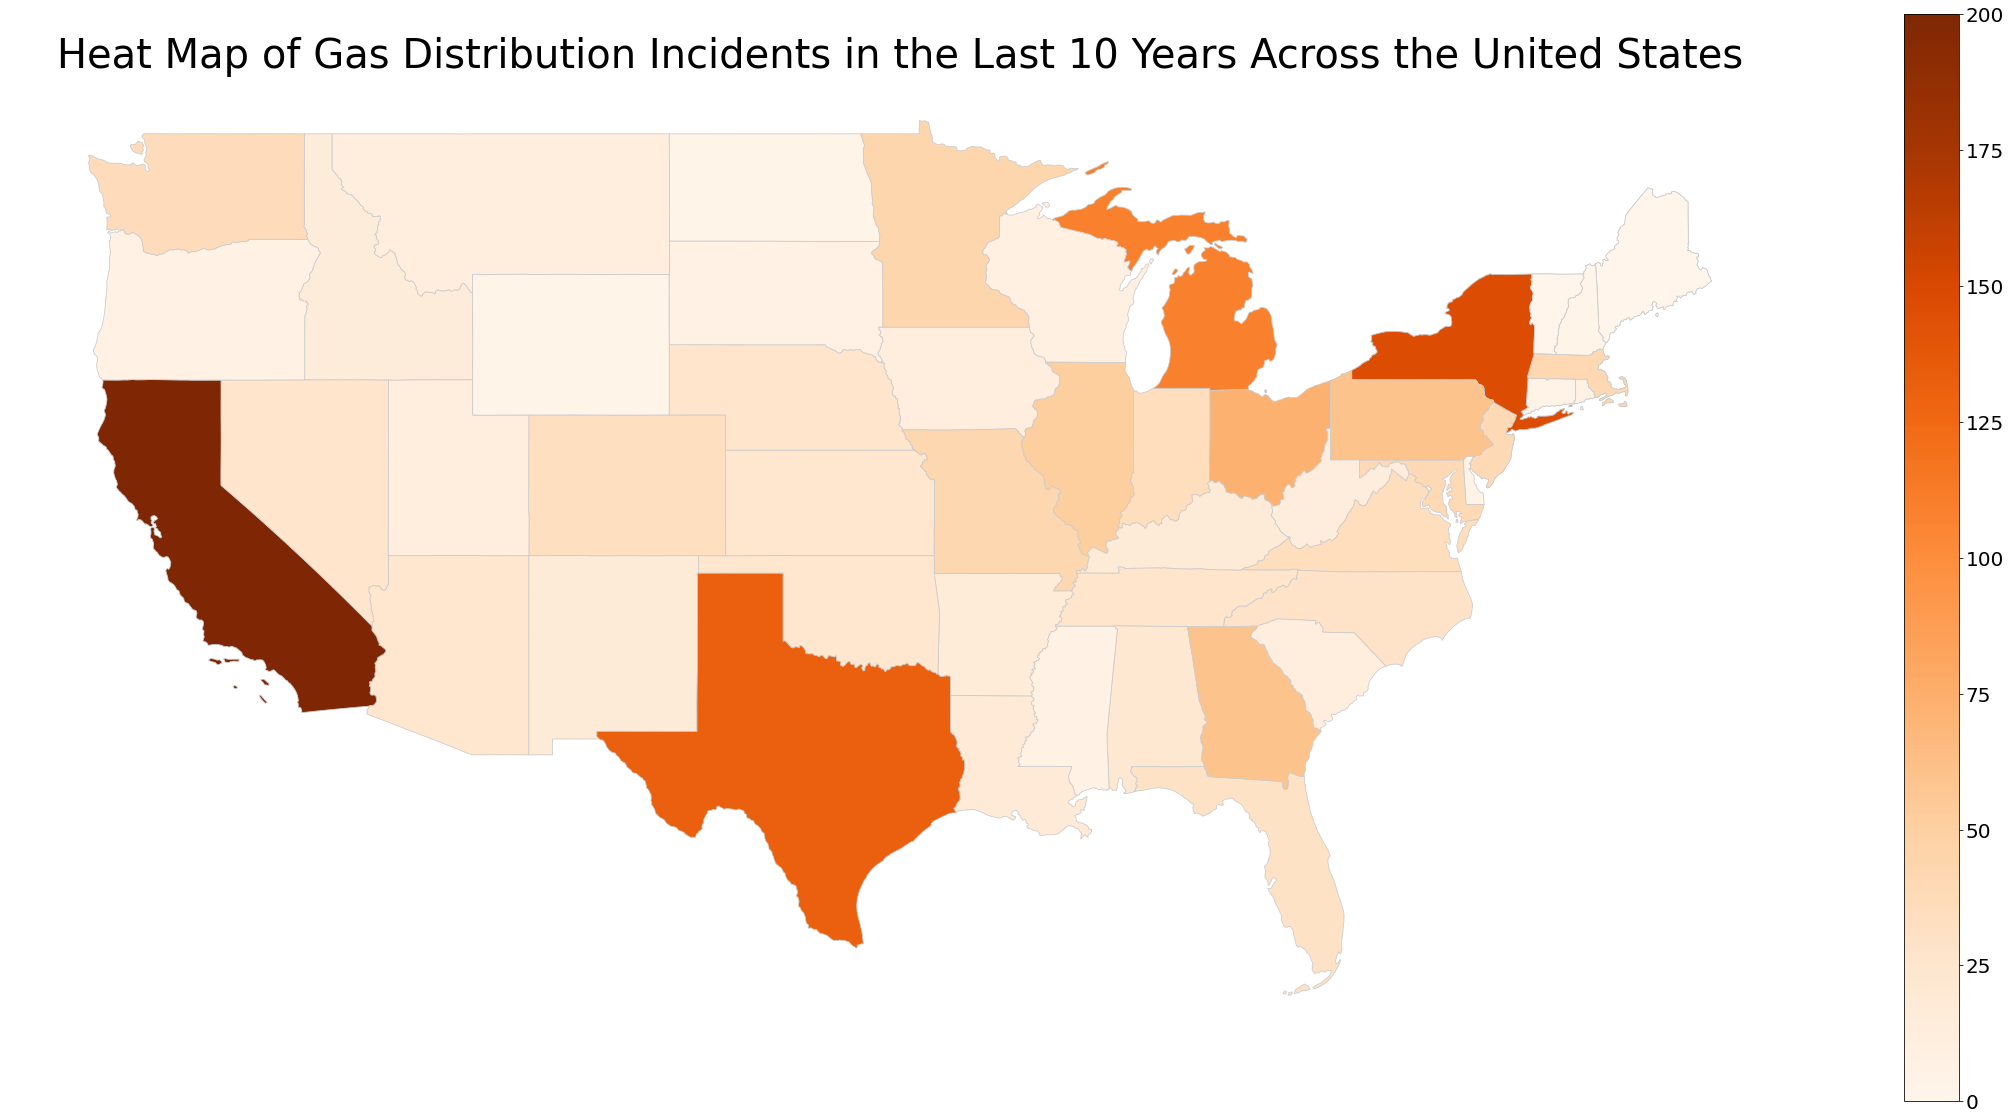

In [207]:
#Plotting the heatmap

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Gas Distribution Incidents in the Last 10 Years Across the United States', fontdict={'fontsize': '40', 'fontweight' : '3'})


#Normalised Colour bar
color = 'Oranges'
vmin, vmax = 0, 200
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)


# Adding the actual Map

merged.plot('Incident_count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

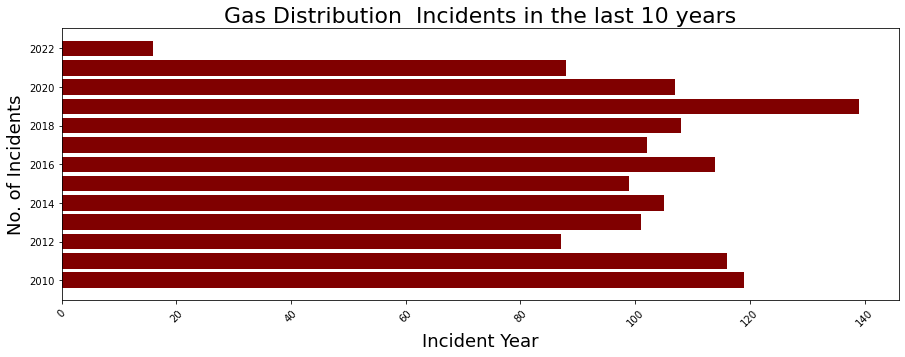

In [213]:

acc_year = Gas_Dist_Acc.groupby(['IYEAR']).count().reset_index()
acc_year.rename(columns = {'REPORT_RECEIVED_DATE':'Incident_count'}, inplace=True)

figure(figsize=(15,5))

# creating the bar plot
plt.barh(acc_year.IYEAR,acc_year.Incident_count , color ='maroon')
 
plt.xlabel("Incident Year",fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel("No. of Incidents", fontsize = 18)
plt.title("Gas Distribution  Incidents in the last 10 years", fontsize = 22)

plt.show()

Having a look at the Injuries, Fatalities and Cuases of the transmission incidents

In [215]:
print('The fatality count is:')
print(Gas_Dist_Acc['FATAL'].value_counts())
print("\n")
print('The injury count is:')
print(Gas_Dist_Acc['INJURE'].value_counts())

The fatality count is:
0    1222
1      64
2      10
3       2
7       1
8       1
5       1
Name: FATAL, dtype: int64


The injury count is:
0     1027
1      182
2       48
3       17
4       11
6        6
10       2
5        2
25       1
33       1
48       1
8        1
17       1
7        1
Name: INJURE, dtype: int64


The fatality rate happens to be larger than the Gas Transmission lines injuries and fatalities, so warrants a closer look. 

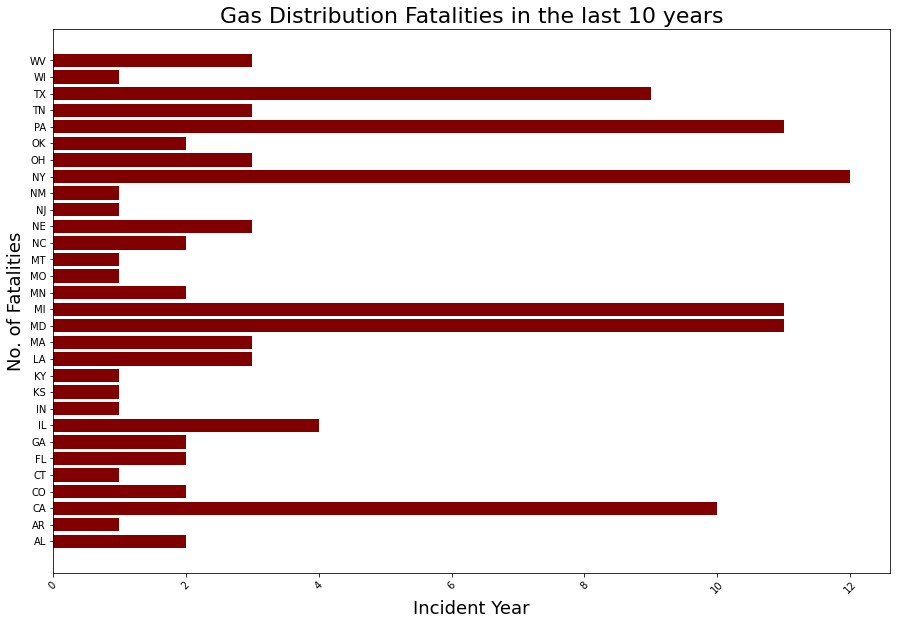

In [261]:
Fatalities = Gas_Dist_Acc[Gas_Dist_Acc['FATALITY_IND']=='YES']
Fatal_by_State = Fatalities.groupby(['LOCATION_STATE_ABBREVIATION']).sum()
Fatality_by_State= Fatal_by_State['FATAL'].reset_index()
Fatality_by_State.rename(columns = {'LOCATION_STATE_ABBREVIATION':'State','FATAL':'Number_Fatalities'}, inplace=True)


# creating the bar plot
figure(figsize=(15,10))
plt.barh(Fatality_by_State.State,Fatality_by_State.Number_Fatalities , color ='maroon')
 
plt.xlabel("Incident Year",fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel("No. of Fatalities", fontsize = 18)
plt.title("Gas Distribution Fatalities in the last 10 years", fontsize = 22)

plt.show()

# Doing the same thing for injuries (maybe with a heatmap this time) 

In [262]:
Injuries = Gas_Dist_Acc[Gas_Dist_Acc['INJURY_IND']=='YES']
Injured_by_State = Injuries.groupby(['LOCATION_STATE_ABBREVIATION']).sum()
Injury_by_State= Injured_by_State['INJURE'].reset_index()
Injury_by_State.rename(columns = {'LOCATION_STATE_ABBREVIATION':'State','INJURE':'Number_Injuries'}, inplace=True)

In [265]:
#joining the shape file with the incident data file
merged = states.set_index('STUSPS').join(Injury_by_State.set_index('State'))
merged = merged.reset_index()
merged = merged.fillna(0)
merged.rename(columns={'index':'State'}, inplace=True)
merged[['State','Number_Injuries']].max()

State                WY
Number_Injuries    87.0
dtype: object

<AxesSubplot:title={'center':'Heat Map of Gas Distribution Injuries in the Last 10 Years Across the United States'}>

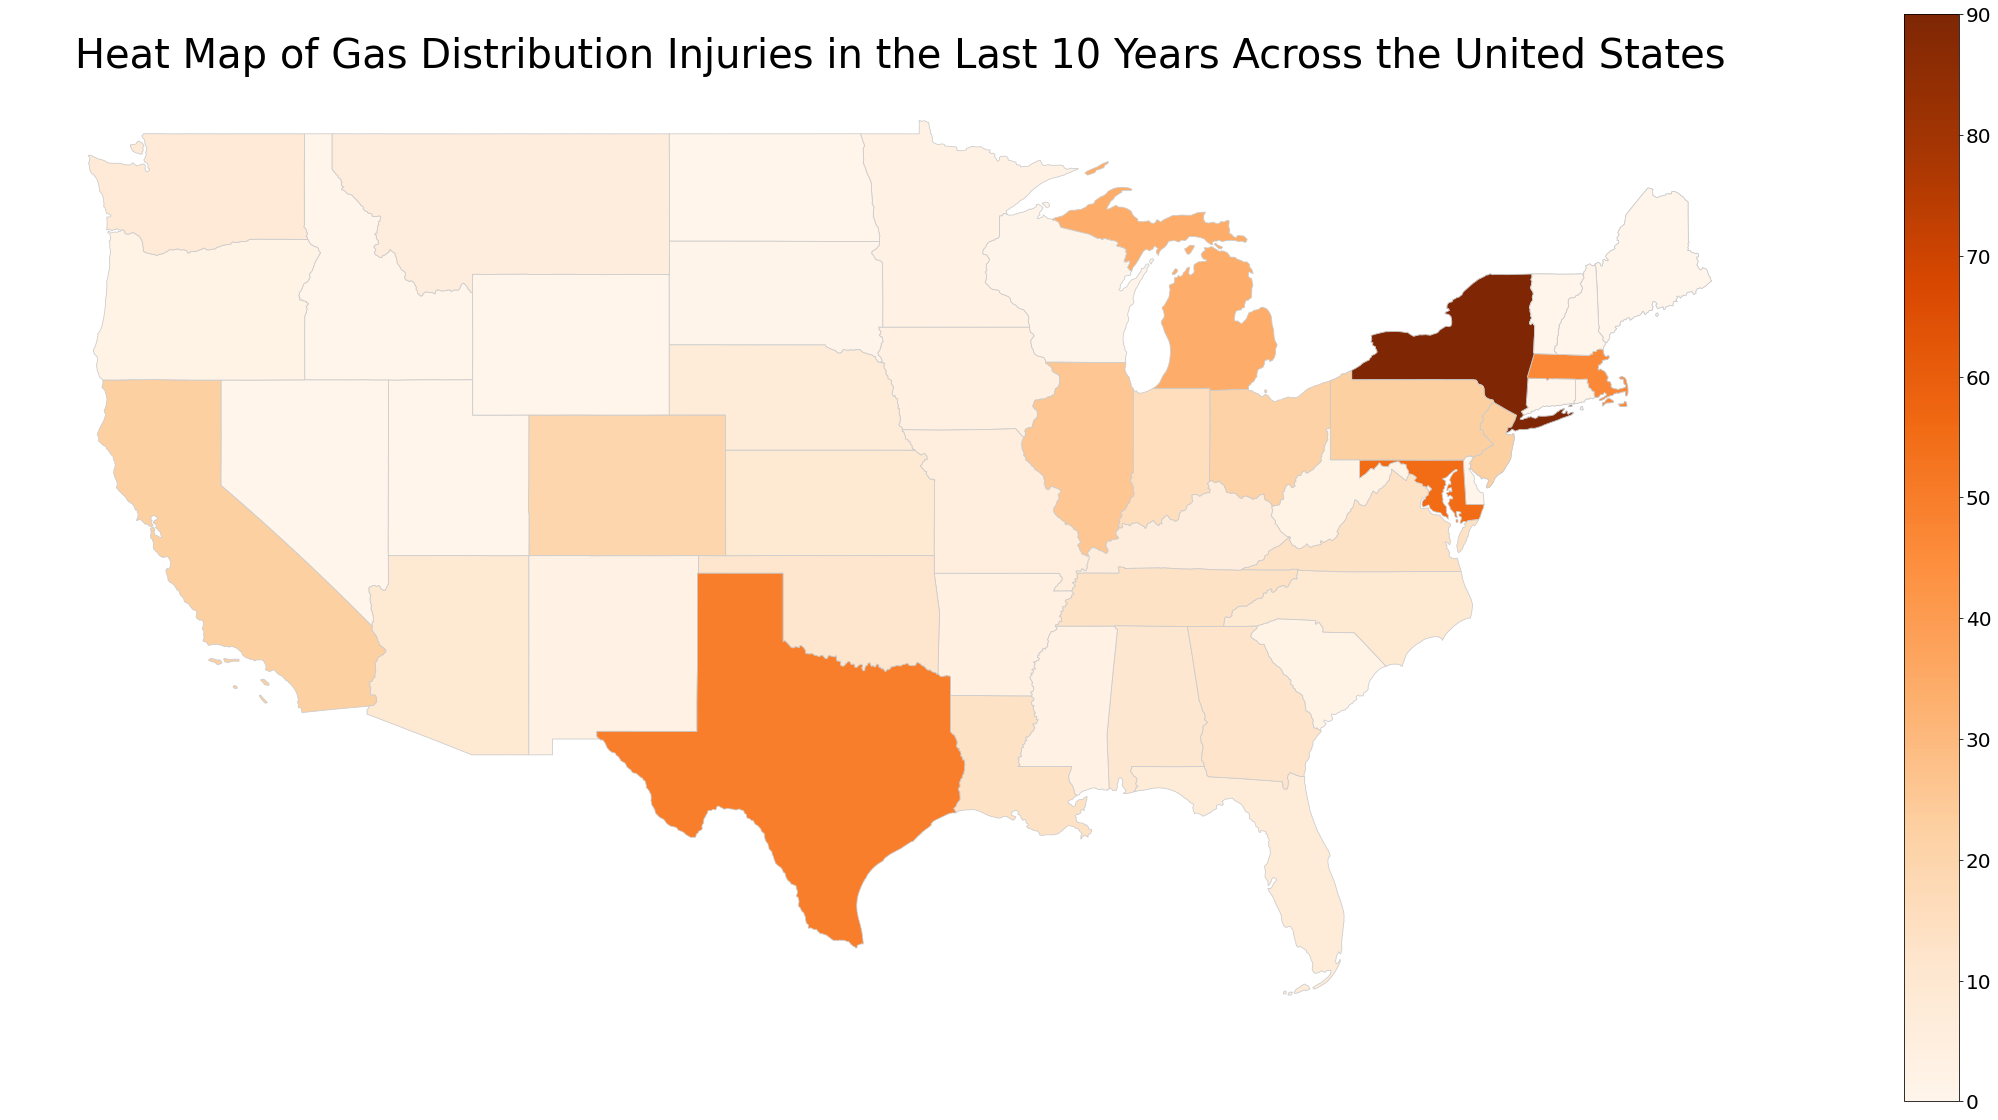

In [266]:
#Plotting the heatmap
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Gas Distribution Injuries in the Last 10 Years Across the United States'
, fontdict={'fontsize': '40', 'fontweight' : '3'})
#Normalised Colour bar
color = 'Oranges'
vmin, vmax = 0, 90
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
# Adding the actual Map
merged.plot('Number_Injuries', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [269]:
Gas_Dist_Acc.CAUSE.value_counts()

EXCAVATION DAMAGE                   428
OTHER OUTSIDE FORCE DAMAGE          407
OTHER INCIDENT CAUSE                 98
INCORRECT OPERATION                  96
NATURAL FORCE DAMAGE                 93
MATERIAL FAILURE OF PIPE OR WELD     90
EQUIPMENT FAILURE                    57
CORROSION FAILURE                    32
Name: CAUSE, dtype: int64

In [270]:
Gas_Dist_Acc.CAUSE_DETAILS.value_counts()

EXCAVATION DAMAGE BY THIRD PARTY                                                                                                        373
DAMAGE BY CAR, TRUCK, OR OTHER MOTORIZED VEHICLE/EQUIPMENT NOT ENGAGED IN EXCAVATION                                                    182
NEARBY INDUSTRIAL, MAN-MADE, OR OTHER FIRE/EXPLOSION AS PRIMARY CAUSE OF INCIDENT                                                        83
OTHER OUTSIDE FORCE DAMAGE                                                                                                               77
OTHER INCORRECT OPERATION                                                                                                                51
MISCELLANEOUS                                                                                                                            49
UNKNOWN                                                                                                                                  49
ELECTRICAL ARCING FR

In [ ]:
Gas_Dist_Acc.iloc[58]

REPORT_RECEIVED_DATE                                            8/13/2021
IYEAR                                                                2021
NAME                                           SOUTHERN PUBLIC SERVICE CO
LOCATION_STREET_ADDRESS                                26 CLINES ADDITION
LOCATION_CITY_NAME                                                  DAVIN
LOCATION_COUNTY_NAME                                                LOGAN
LOCATION_STATE_ABBREVIATION                                            WV
LOCATION_POSTAL_CODE                                                25617
LOCATION_LATITUDE                                                   37.75
LOCATION_LONGITUDE                                              -81.81667
COMMODITY_RELEASED_TYPE                                       NATURAL GAS
UNINTENTIONAL_RELEASE                                                 1.0
INTENTIONAL_RELEASE                                                   0.0
FATALITY_IND                          